# SBRCT Microarray Data
Gene expression arrays are an important new technology in biology. The data for this example form a matrix of 2308 genes (columns) and 63 samples (rows), from a set of microarray experiments. Each expression value is a log-ratio $log(R/G)$. $R$ is the amount of gene-specific RNA in the target sample that hybridizes to a particular (gene-specific) spot on the microarray, and $G$ is the corresponding amount of RNA from a reference sample. The samples arose from small, round blue-cell tumors (SRBCT) found in children, and are classified into four major types: BL (Burkitt lymphoma), EWS (Ewing's sarcoma), NB (neurablastoma), and RMS (rhabdomyosarcoma). There is an additional test data set of 20 observations.
SBRCT gene expression data.

Cancer classes are labelled 1,2,3,4 for c("EWS","RMS","NB","BL")

The implementation is based on the "Diagnosis of multiple cancer types by shrunkencentroids of gene expression", Robert Tibshirani, Trevor Hastie, Balasubramanian Narasimhan, and Gilbert Chu, https://www.pnas.org/content/pnas/99/10/6567.full.pdf

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

# define commonly used colors
GRAY1, GRAY4, GRAY8, PURPLE = '#231F20', '#646369', '#A6A6A5', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

## Load and Prepare Data

In [2]:
data = np.load('../data/srbct.npy.npz')['data']

# last column contains 'is train' flag
is_train = data[:,-1].astype(int)
data_test = data[is_train == 0, :]
data_train = data[is_train == 1, :]
# pre-last column contains class
y_train = data_train[:, -2].astype(int)
y_test = data_test[:, -2].astype(int)
X_train = data_train[:, :-2]
X_test = data_test[:, :-2]

## Nearest Shrunken Centroids
The Scikit-Learn provides NearestCentroid class that supports shrink_threshold. It is not very powerfull and gives different result than the book. Next step we will implement our algorithm. 

In [3]:
stratified_kfolds = StratifiedKFold(8, random_state=1)
nearest_centroid_classifier = Pipeline([
    ('scale', StandardScaler()),
    ('ncc', NearestCentroid())]
)
# use grid search to select best shrink_threshold
shrink_threshold_grid_search = GridSearchCV(
    nearest_centroid_classifier,
    {'ncc__shrink_threshold': np.linspace(0, 100, 100)},
    cv=stratified_kfolds,
    iid=True
).fit(X_train, y_train)
best_model = shrink_threshold_grid_search.best_estimator_
print('Test accuracy score',
      accuracy_score(y_test, best_model.predict(X_test)))

Test accuracy score 1.0


## Nearest Shrunken Centroids Implementation
To get exactly the same result as in the book, I have implemented nearest shrunken centroids model.

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score

In [5]:
class ShrunkenCentroid(BaseEstimator, ClassifierMixin):
    """Nearest shrunken centroid classifier.
    Each class is represented by its centroid, with test samples classified to
    the class with the nearest centroid.
    Parameters
    ----------
    delta : float, optional (default = None)
        Delta for shrinking centroids to remove features.
    Attributes
    ----------
    classes_:
        All classes found in the training data set.
    centroids_ :
        Centroid of each class.
    overall_centroid_:
        The overall mean of each feature.
    priors_:
        Class prior probabilities.
    vars_:
        Pooled within-class variances of features.
    shrunken_centroids_:
        Shrunken centroid of each class.
    features_used_:
        The number of features that are not shrunken to the overall centroid.
    """
    def __init__(self, delta: float = 0):
        self.delta = delta

    def fit(self, X: np.ndarray, y: np.array) -> 'ShrunkenCentroid':
        """
        Fit the ShrunkenCentroid model according to the given training data.
        Parameters
        ----------
        X :
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.
        y :
            Target values (integers)
        """
        # relabel target values to start from zero
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        self.classes_ = label_encoder.classes_
        N, p, K = *X.shape, self.classes_.size
        # calculated overall centroid and prior probabilities
        self.overall_centroid_ = np.mean(X, axis=0)
        _, counts = np.unique(y, return_counts=True)
        self.priors_ = counts / N
        # calculate correction coefficients for each class
        m = np.atleast_2d((1/counts - 1/N)**0.5).T
        self.centroids_ =\
            np.vstack([np.mean(X[y == k, :], axis=0) for k in range(K)])
        # pooled within-class variance and deviation of features
        self.vars_ = np.zeros(shape=p)
        for k in range(K):
            self.vars_ += np.sum((X[y == k, :]-self.centroids_[k])**2, axis=0)
        self.vars_ /= (N - K)
        stds = self.vars_ ** 0.5
        # calculate shrunken centroids
        distances = self.centroids_ - self.overall_centroid_
        mean_std = np.median(stds)
        t_stats = distances / (stds + mean_std) / m
        t_stats_shrunken =\
            np.sign(t_stats) * (np.abs(t_stats) - self.delta).clip(0)
        self.shrunken_centroids_ =\
            self.overall_centroid_ + m * (stds + mean_std) * t_stats_shrunken
        self.features_used_ = np.sum(np.sum(np.abs(
            self.shrunken_centroids_ - self.overall_centroid_), axis=0) > 0)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Perform classification on an array of test vectors X.
        The predicted class C for each sample in X is returned.
        Parameters
        ----------
        X : array, shape = [n_samples, n_features]
        Returns
        -------
        C : array, shape = [n_samples]
        """
        N, K = X.shape[0], self.classes_.size
        discriminators = np.zeros(shape=(N, K))
        for i in range(N):
            discriminators[i] = -np.sum(
                (self.shrunken_centroids_ - X[i])**2 / self.vars_, axis=1) +\
                                2*np.log(self.priors_)
        return self.classes_[np.argmax(discriminators, axis=1)]

In [6]:
deltas = np.linspace(0, 8, 14*4 + 1)
n_genes, err_cv, err_train, err_test = [], [], [], []
for delta in deltas:
    sc = ShrunkenCentroid(delta=delta).fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, sc.predict(X_train))
    test_accuracy = accuracy_score(y_test, sc.predict(X_test))
    cv_accuracy = np.mean(cross_val_score(
        ShrunkenCentroid(delta=delta), X_train, y_train, cv=8))
    err_cv.append(1 - cv_accuracy)
    err_train.append(1 - train_accuracy)
    err_test.append(1 - test_accuracy)
    n_genes.append(sc.features_used_)

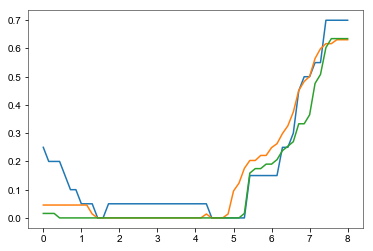

In [7]:
plt.plot(deltas, err_test)
plt.plot(deltas, err_cv)
plt.plot(deltas, err_train)

In [8]:
sc = ShrunkenCentroid(delta=4.38).fit(X_train, y_train)

Text(1.2,-300,'Centroids: Average Expression Centered at Overall Centroid')

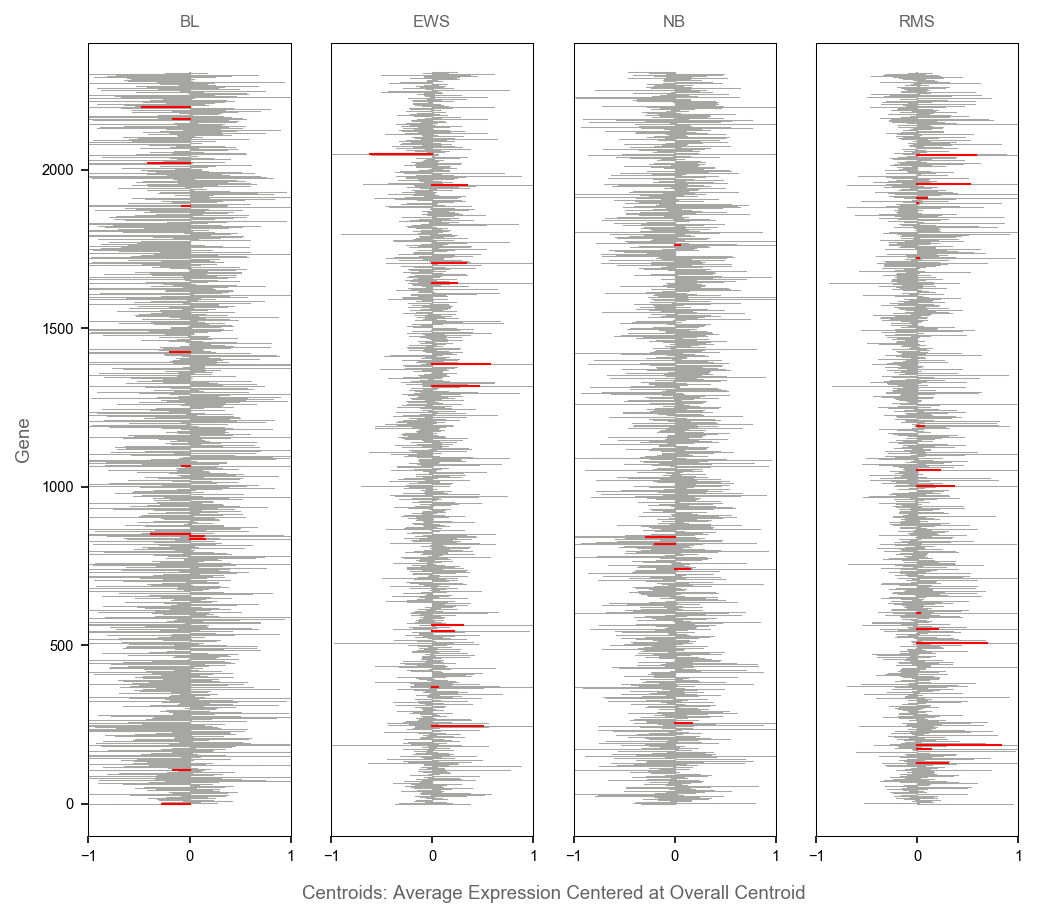

In [9]:
def plot_means(ax, model, class_index, title, hide_y_labels=True):
    means = sc.centroids_[class_index] - sc.overall_centroid_
    d_shrunken = sc.shrunken_centroids_[class_index] - sc.overall_centroid_
    for i in range(means.shape[0]):
        ax.plot([0, means[i]], [i, i], linewidth=0.5, color=GRAY8)
    for i in range(d_shrunken.shape[0]):
        if d_shrunken[i] == 0:
            continue
        ax.plot([0, d_shrunken[i]], [i, i], linewidth=1, color='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-100, 2400)
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(7)
    if hide_y_labels:
        ax.tick_params(labelleft=False, left=False)
    else:
        ax.set_ylabel('Gene', color=GRAY4, fontsize=9)
    ax.text(0, 2450, title, color=GRAY4, fontsize=8,
                horizontalalignment='center')        

fig, axarr = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(8, 7), dpi=150)
plot_means(axarr[0], sc, 0, 'BL', False)
plot_means(axarr[1], sc, 1, 'EWS')
plot_means(axarr[2], sc, 2, 'NB')
plot_means(axarr[3], sc, 3, 'RMS')
axarr[1].text(1.2, -300, 'Centroids: Average Expression Centered at Overall Centroid',
              color=GRAY4, fontsize=9, horizontalalignment='center')